In [3]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kstest, norm, expon, gamma, lognorm, beta

# Inspecting the distributions
In this notebook, we test the distributions for the different computed features; based on these distributions, we decide which Kolmogorov Smirnoff (KS) test we conduct. We divide the features into two categories, the continuous features representing the readability, Information Complexity, and Vader Scores, and the discrete features representing the count functions NER and POS tags. We compute the KS test only for the continuous features since the discrete features are not used to measure some property but solely as a count of tags.
https://rcompanion.org/handbook/I_01.html#:~:text=It%20is%20sometimes%20permissible%20to,data%20or%20other%20discrete%20data.


## Importing the data
- The imported data is then processed Liar Dataset through the faKy library.
- All the features, Readability, Information Complexity, Vader scores, NER, and POS tags are computed in a different notebook.
- We have stored the data in a new data frame and now import this data frame for efficiency purposes.
- We classify the qualative labels true(0), false(1) and in Between (2)
- We also define in which columns the labels are stored in the data frame to compute the significance of the features 
- At last, we divide the data into three labels, True, False, and In between data corresponding with the qualitative labels 0,1,2.


In [4]:
Liar_computed = pd.read_csv('/Users/sandrobarreshamers/Thesis_IS_fake_news/ThesisData/Liar_computed_final_version.csv')

In [5]:
Liar_computed.head(2)

,Unnamed: 0,json_id,claim,object,binary label,readability,compressed_size,vader_neg,vader_neu,vader_pos,...,pos_NOUN,pos_NUM,pos_PART,pos_PRON,pos_PROPN,pos_PUNCT,pos_SCONJ,pos_SYM,pos_VERB,pos_X
0,0,10540.json,half-true,When did the decline of coal start? It started...,2,71.815000,11444,0.000,0.902,0.098,...,5.0,0.0,1.0,1.0,4.0,4.0,0.0,0.0,4.0,0.0
1,1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",2,71.781579,9089,0.107,0.687,0.206,...,2.0,0.0,1.0,0.0,7.0,3.0,0.0,0.0,3.0,0.0


## Ploting the features
We plot the distributions with the matplotlib library; we show two figures, one for the continuous and one for the discrete features.

### Plotting the continuous features

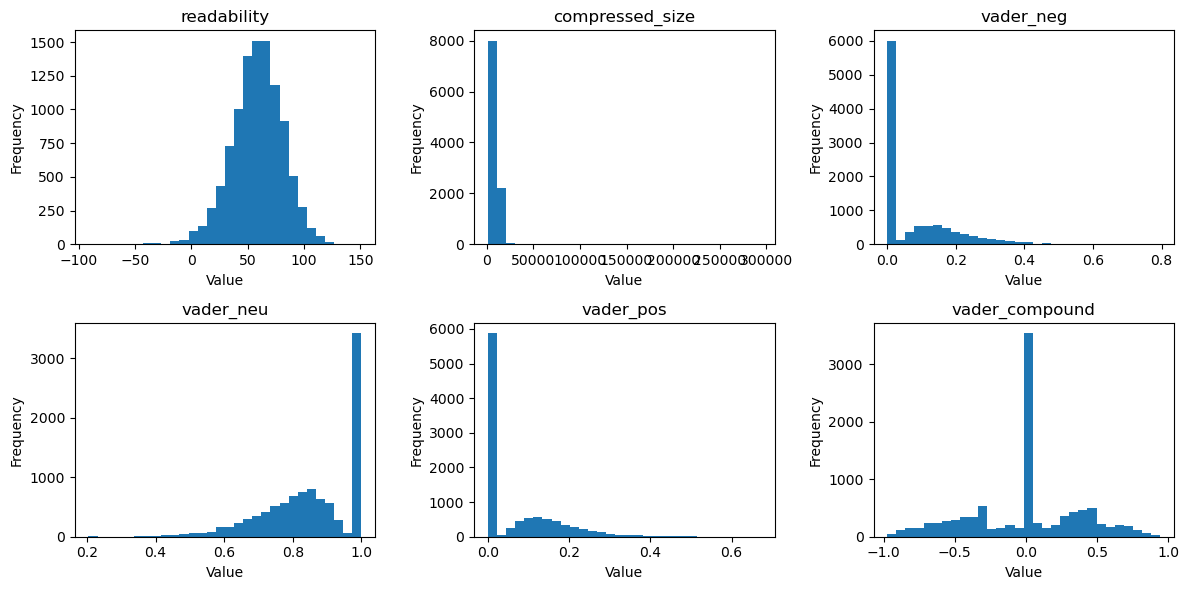

In [13]:
continuous_features = ['readability', 'compressed_size', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']

plt.figure(figsize=(12, 6))

for i, feature in enumerate(continuous_features, start=1):
    plt.subplot(2, 3, i)
    plt.hist(Liar_computed[feature].dropna(), bins=30)
    plt.title(feature)
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.tight_layout()

plt.savefig('distributions.svg', format='svg')

plt.show()





### Plotting the discrete features

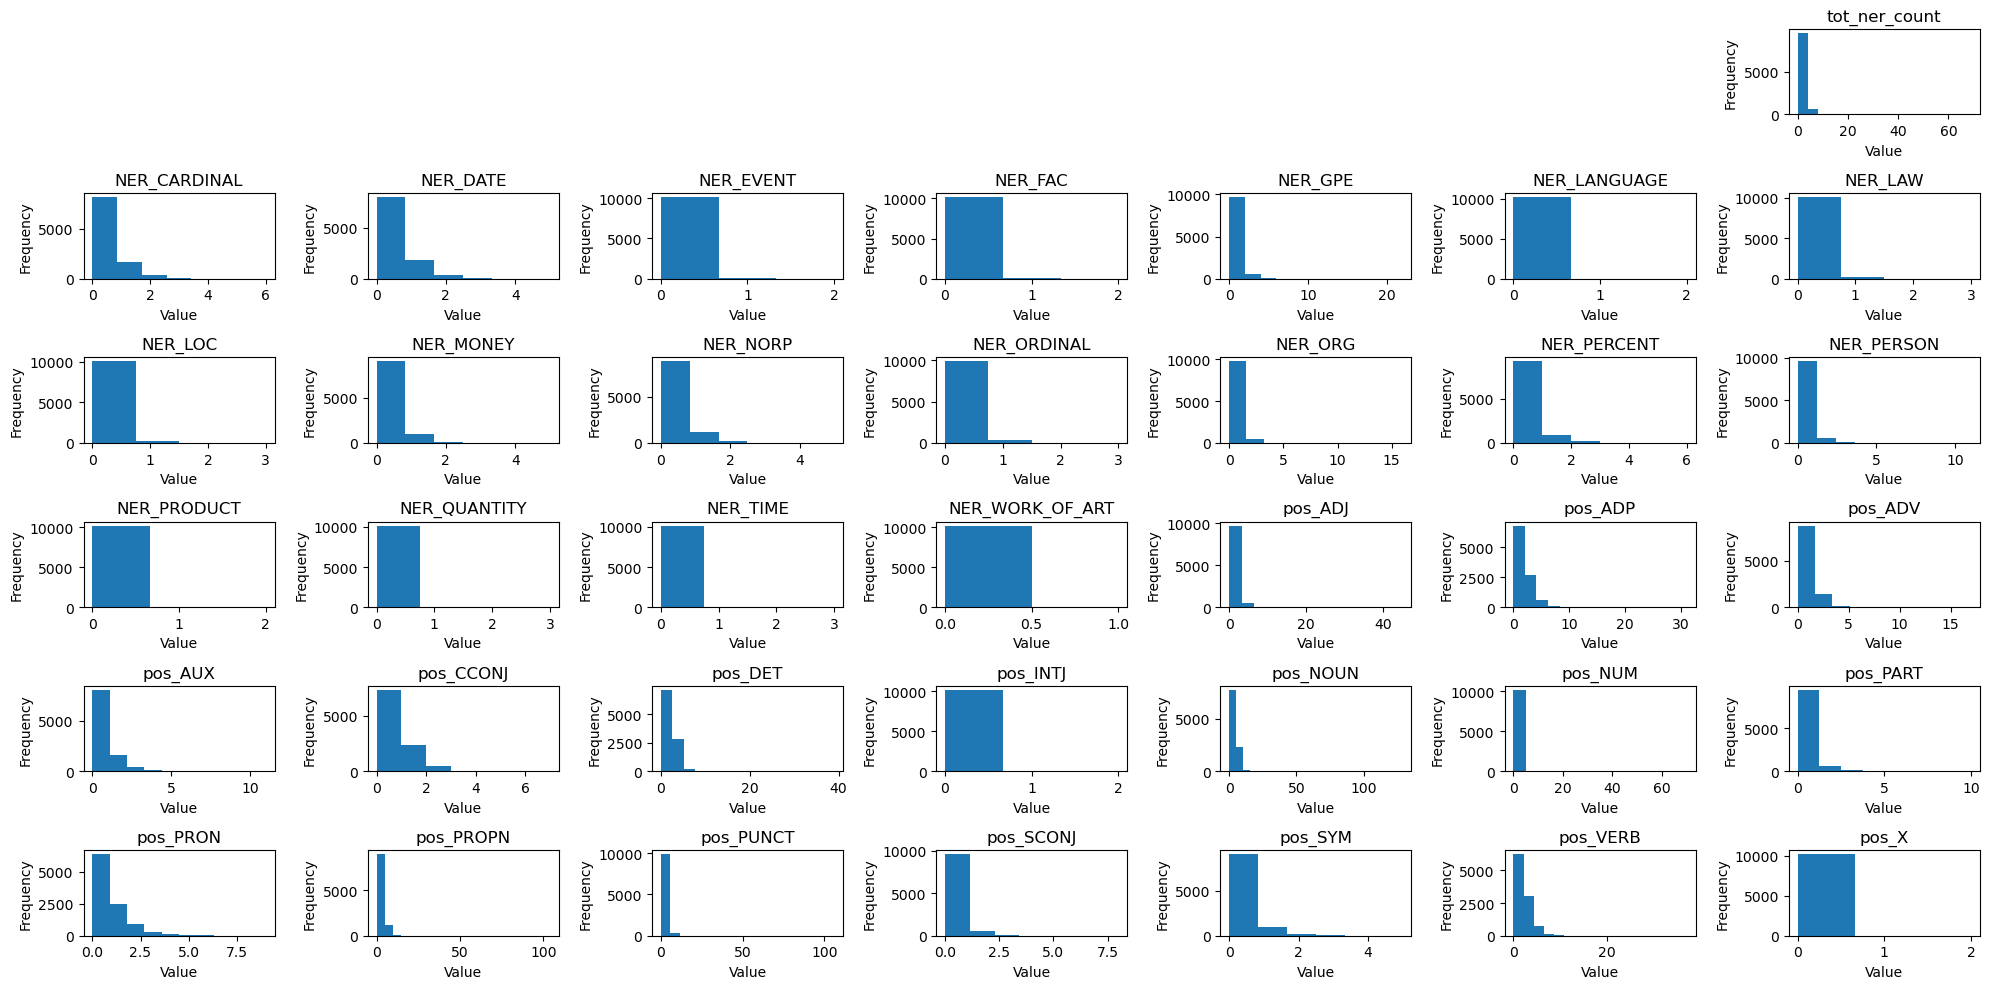

In [7]:
import matplotlib.pyplot as plt

discrete_features = ['tot_ner_count', 'NER_CARDINAL', 'NER_DATE', 'NER_EVENT', 'NER_FAC', 'NER_GPE',
                     'NER_LANGUAGE', 'NER_LAW', 'NER_LOC', 'NER_MONEY', 'NER_NORP', 'NER_ORDINAL',
                     'NER_ORG', 'NER_PERCENT', 'NER_PERSON', 'NER_PRODUCT', 'NER_QUANTITY',
                     'NER_TIME', 'NER_WORK_OF_ART', 'pos_ADJ', 'pos_ADP', 'pos_ADV', 'pos_AUX',
                     'pos_CCONJ', 'pos_DET', 'pos_INTJ', 'pos_NOUN', 'pos_NUM', 'pos_PART',
                     'pos_PRON', 'pos_PROPN', 'pos_PUNCT', 'pos_SCONJ', 'pos_SYM', 'pos_VERB', 'pos_X']

plt.figure(figsize=(20, 10))

for i, feature in enumerate(discrete_features, start=7):
    plt.subplot(6, 7, i)
    plt.hist(Liar_computed[feature].dropna(), bins=len(Liar_computed[feature].unique()))
    plt.title(feature)
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



### Test for parametic
- In this code block, we perform a test to test if the continuous features are parametric or not.
- We first build a dictionary with the continuous features
- Based on the plots for the continuous features, we decide which KS test to conduct; the plots are either normally distributed or skewed either left or right
- Subsequently, we iterate through the dictionary and perform the KS test
- We populate a DF, which returns the feature if it is non-parametric or not, and the corresponding p-value
- At last, we print the DF as a latex table

In [8]:
from scipy.stats import kstest, lognorm

results = []

for feature in continuous_features:
    data = Liar_computed[feature]
    
    if feature == 'compressed_size' or feature == 'vader_neg' or feature == 'vader_pos' or feature == 'vader_neu':
        data = data[data > 0]
        shape, loc, scale = lognorm.fit(data, floc=0)
        statistic, p_value = kstest(data, 'lognorm', args=(shape,), alternative='two-sided')
        distribution_type = 'Log-normal (left-skewed)' if feature != 'vader_neu' else 'Log-normal (right-skewed)'
        
    elif feature == 'vader_compound':
        statistic, p_value = kstest(data, 'norm')
        distribution_type = 'Normal'
        
    else:
        statistic, p_value = kstest(data, 'norm')
        distribution_type = 'Normal'
    
    non_parametric = p_value < 0.05
    results.append({'Feature': feature, 'Distribution': distribution_type, 'non-parametric': non_parametric, 'p-value': p_value})

results_df = pd.DataFrame(results)
print(results_df)


           Feature               Distribution  non-parametric  p-value
0  compressed_size   Log-normal (left-skewed)            True      0.0
1      readability                     Normal            True      0.0
2        vader_neg   Log-normal (left-skewed)            True      0.0
3        vader_neu  Log-normal (right-skewed)            True      0.0
4        vader_pos   Log-normal (left-skewed)            True      0.0
5   vader_compound                     Normal            True      0.0


In [9]:
latex_table_KS_test = results_df.to_latex(index=False, float_format=lambda x: "%.2f" % x)
print(latex_table_KS_test)

\begin{tabular}{lllr}
\toprule
        Feature &              Distribution &  non-parametric &  p-value \\
\midrule
compressed\_size &  Log-normal (left-skewed) &            True &     0.00 \\
    readability &                    Normal &            True &     0.00 \\
      vader\_neg &  Log-normal (left-skewed) &            True &     0.00 \\
      vader\_neu & Log-normal (right-skewed) &            True &     0.00 \\
      vader\_pos &  Log-normal (left-skewed) &            True &     0.00 \\
 vader\_compound &                    Normal &            True &     0.00 \\
\bottomrule
\end{tabular}



/var/folders/0q/8tgppr255xx8v40x26xhhmhr0000gn/T/ipykernel_5068/293441709.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table_KS_test = results_df.to_latex(index=False, float_format=lambda x: "%.2f" % x)


# End of notebook